In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

from tools_fast import *
from clustering import cluster, cluster_net
from hc_graph import hc_stock, hc_piechart, hc_spiderweb

<IPython.core.display.Javascript object>

Open console to check js libs were loaded in page


In [3]:
fund_name = 'CARMPAT'
pd.read_csv(r"financial_data/hfrx_index_names.csv", index_col=0)

,Full Name
Name,
HFRXAR,HFRX Absolute Return Index
HFRXDS,HFRX ED: Distressed Restructuring Index
HFRXMA,HFRX ED: Merger Arbitrage Index
HFRXSS,HFRX ED: Special Situations Index
HFRXEMN,HFRX EH: Equity Market Neutral Index
HFRXEHG,HFRX EH: Fundamental Growth Index
HFRXEHV,HFRX EH: Fundamental Value Index
HFRXEMC,HFRX Emerging Markets Composite Index
HFRXEW,HFRX Equal Weighted Strategies Index


### Financial data loads and cleaning

In [4]:
# US rate
US_rate = pd.read_csv(r"financial_data/USD_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['3M']
EUR_rate = pd.read_csv(r"financial_data/EUR_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['3M']
EUR_USD = pd.read_csv(r"financial_data/FX_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['EUR/USD']

# HFRX
hfrx_all = pd.read_csv(r"financial_data/hfrx_daily_index_data.csv", index_col=0, parse_dates=True, dayfirst=True).ffill()

hfrx = make_ER(hfrx_all[[fund_name]].dropna(), EUR_rate)
hfrx = make_FXHedge(hfrx, EUR_USD)
# BNP

bnp = pd.read_csv(r"financial_data/bnp_data_long_term.csv", index_col=0, parse_dates=True, dayfirst=True) #[["BNPIFEU","BNPIFUS",
                 #"BNPIFJP","BNPIFCN","BNPIFFR","BNPIFGE","BNPIFGB","BNPIFCH","BNPIFKR","BNPIFUSC","BNPIFBR",
                 #"BNPIFAU","BNPIFHK","BNPIFTW","BNPIFSG","BNPIFIT","BNPIFSP","BNPIFSW","BNPIFNE","BNPIFRU","BNPIFEM"]]

risk_premia = pd.read_pickle("financial_data/risk_premia_ER_FX_USD.pkl") #[["BNPICCE3","BNPIVMRU","BNPIAIRT","BNPIAIRU",
                  #"BNPIEC03","BNPIPLEE","BNPIPMEE","BNPIPQEE","BNPIPVEE","BNPILUEE","BNPIPMUH","BNPIPQUH",
                  #"BNPIPVUH","BNPIAIRG","BNPIAIRJ","BNPIAIRE"]]

In [5]:
df_info = pd.read_csv(r"financial_data/bnp_info.csv", index_col=0)
df_info.head()

,Asset Class,Style
Ticker,,
BNPIDRXA,Commodity,Carry
BNPIF3AX,Commodity,Carry
BNPIF3XM,Commodity,Momentum
BPFXSTGU,FX,Value
BNPICCE3,Equity,Carry


In [6]:
prices_all = hfrx.join(bnp, how="left").join(risk_premia,how="left").ffill()
prices_all.head()

,CARMPAT,BNPIFEU,BNPIFUS,BNPIFJP,BNPIFCN,BNPIFFR,BNPIFGE,BNPIFGB,BNPIFCH,BNPIFKR,...,BNPIPMEE,BNPIPQEE,BNPIPVEE,BNPILUEE,BNPIPMUH,BNPIPQUH,BNPIPVUH,BNPIMDEA,BNPIAIFH,BNPICVXA
2003-03-31,1.000000,119.746431,137.960807,55.002147,22.904581,97.681949,75.088460,85.874648,131.164048,105.5605,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-04-01,1.001058,121.270258,139.983719,55.886297,22.952384,98.292425,75.692747,87.678180,132.780174,105.7853,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-04-02,0.998513,127.035774,143.698758,56.353244,23.040957,102.304380,79.676099,89.466028,137.079115,107.0412,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-04-03,0.997966,128.539724,142.655403,55.808539,22.909725,103.959571,80.267351,89.862012,138.848431,108.1501,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-04-04,0.998324,130.361973,143.316375,56.487221,22.997248,105.782754,81.131912,90.727931,141.003673,110.5014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
returns_all = prices_all.pct_change().iloc[1:]
hrfx_returns = returns_all[[fund_name]]
returns_all = returns_all.drop(fund_name, axis=1)
prices_all = prices_all.drop(fund_name, axis=1)
prices_all = prices_all.bfill()

In [8]:
alpha = hrfx_returns[fund_name].autocorr(lag=1)
hrfx_returns_adj = ((hrfx_returns - alpha * hrfx_returns.shift(1)) / (1. - alpha)).fillna(0) # 'liquidity adjustment' for
                                                                                             # removing returns autocorrelation
beta = hrfx_returns_adj[fund_name].autocorr(lag=1)

Auto-correlation of CARMPAT returns : 0.0425605293820816
Auto-correlation of CARMPAT adjusted returns : 0.0006718965636518404


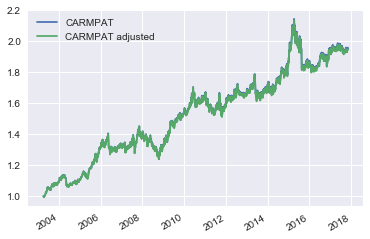

In [9]:
print("Auto-correlation of",fund_name,"returns :", alpha)
print("Auto-correlation of",fund_name,"adjusted returns :", beta)
ax = (1 + hrfx_returns).cumprod().plot()
_ = (1 + hrfx_returns_adj).cumprod()[fund_name].plot(label=fund_name + ' adjusted', legend=True, ax=ax)

## Estimation of the exposures

In [10]:
size = 126
freq = 5
freq_ml = 10
nu = 1.0
tau = 0.1

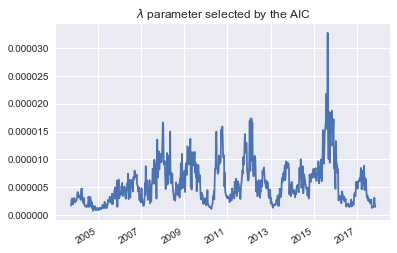

Wall time: 48.4 s


In [11]:
%%time
df_weight_aic, _ = lasso_regression_ic(hrfx_returns, returns_all,sample_length=size, frequency=freq, criterion='aic')
prices_for_track_aic = prices_all.loc[df_weight_aic.index[0]:]

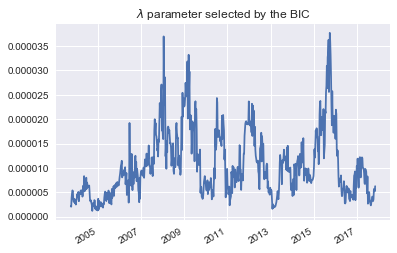

Wall time: 45.8 s


In [12]:
%%time
df_weight_bic, _ = lasso_regression_ic(hrfx_returns, returns_all,sample_length=size, frequency=freq, criterion='bic')
prices_for_track_bic = prices_all.loc[df_weight_bic.index[0]:]

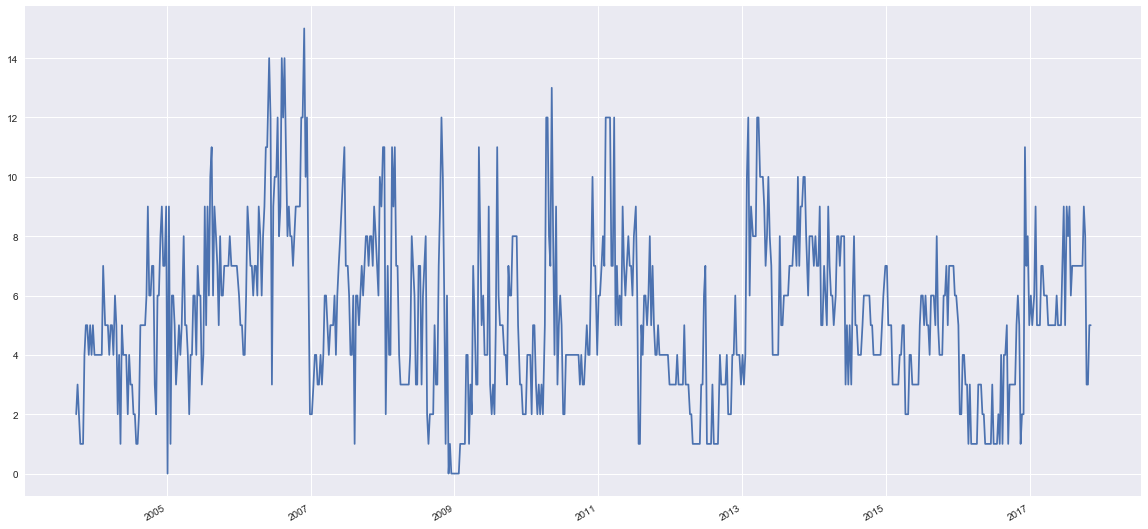

In [13]:
(df_weight_bic != 0).sum(axis=1).plot(figsize=(20,10))

In [14]:
%%time
df_weight_kalman = kalman_filter(hrfx_returns, returns_all,freq, sigma_weight=1. , sigma_return=nu)

prices_for_track_kalman = prices_all.loc[df_weight_kalman.index[0]:]

Wall time: 322 ms


In [15]:
%%time
df_weight_ml_kalman, _ = ml_kalman_filter(hrfx_returns, returns_all, freq_ml, tau=tau)

Wall time: 11.6 s


In [16]:
%%time
df_weight_kalman_bic = selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='bic')

prices_for_track_kalman_bic = prices_all.loc[df_weight_kalman_bic.index[0]:]

Wall time: 45.3 s


In [17]:
%%time
df_weight_ml_kalman_bic = ml_selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq_ml,
                                                     tau=tau, criterion='bic')

prices_for_track_ml_kalman_bic = prices_all.loc[df_weight_ml_kalman_bic.index[0]:]

Wall time: 33.8 s


In [18]:
%%time
df_weight_kalman_aic = selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='aic')

prices_for_track_kalman_aic = prices_all.loc[df_weight_kalman_aic.index[0]:]

Wall time: 45.1 s


In [19]:
%%time
df_weight_ml_kalman_aic = ml_selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq_ml,
                                                     tau=tau, criterion='aic')

prices_for_track_ml_kalman_aic = prices_all.loc[df_weight_ml_kalman_aic.index[0]:]

Wall time: 30 s


## Replication

In [20]:
%%time
tc = 0.0005
lag = 3

replication_aic = make_track(prices_for_track_aic, df_weight_aic, tc=tc, lag=lag)
df_res = hfrx.loc[replication_aic.index]
df_res["Lasso AIC"] = replication_aic

replication_bic = make_track(prices_for_track_bic, df_weight_bic, tc=tc, lag=lag)
df_res["Lasso BIC"] = replication_bic

replication_kalman = make_track(prices_for_track_kalman, df_weight_kalman, tc=tc, lag=lag).loc[df_res.index[0]:]
df_res["Kalman"] = replication_kalman

replication_ml_kalman = make_track(prices_for_track_kalman, df_weight_ml_kalman, tc=tc, lag=lag).loc[df_res.index[0]:]
df_res["ML Kalman"] = replication_ml_kalman

replication_kalman_aic = make_track(prices_for_track_kalman_aic, df_weight_kalman_aic, tc=tc, lag=lag).loc[df_res.index[0]:]
df_res["Kalman AIC"] = replication_kalman_aic

replication_ml_kalman_aic = make_track(prices_for_track_ml_kalman_aic, df_weight_ml_kalman_aic, tc=tc, lag=lag).loc[df_res.index[0]:]
df_res["ML Kalman AIC"] = replication_ml_kalman_aic

replication_kalman_bic = make_track(prices_for_track_kalman_bic, df_weight_kalman_bic, tc=tc, lag=lag).loc[df_res.index[0]:]
df_res["Kalman BIC"] = replication_kalman_bic

replication_ml_kalman_bic = make_track(prices_for_track_ml_kalman_bic, df_weight_ml_kalman_bic, tc=tc, lag=lag).loc[df_res.index[0]:]
df_res["ML Kalman BIC"] = replication_ml_kalman_bic

Wall time: 155 ms


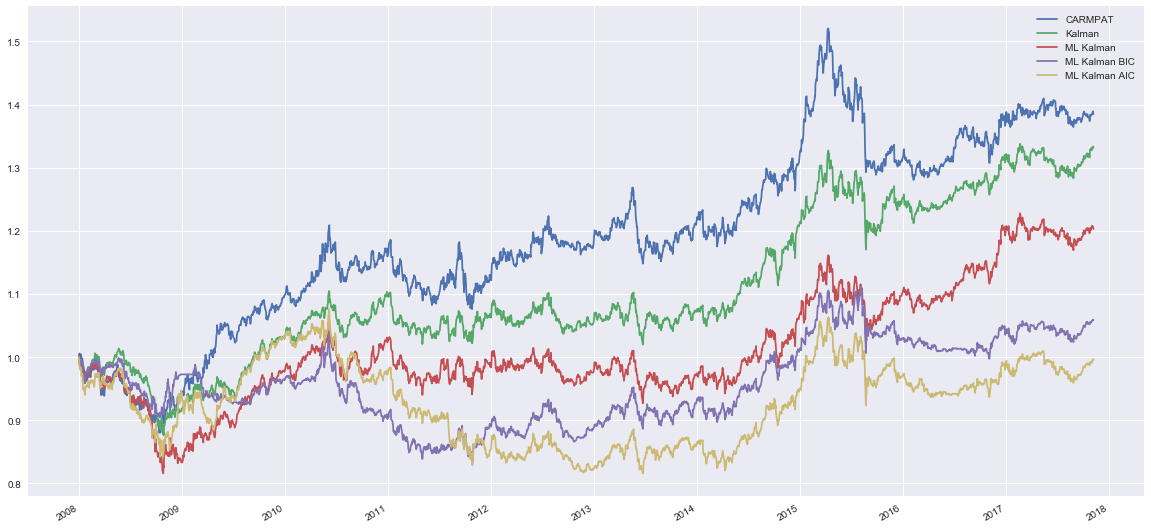

In [54]:
df_res = df_res.loc['2008':]
df_res = (df_res / df_res.iloc[0])
df_res[[fund_name, 'Kalman', 'ML Kalman', "ML Kalman BIC", "ML Kalman AIC"]].plot(figsize=(20,10))

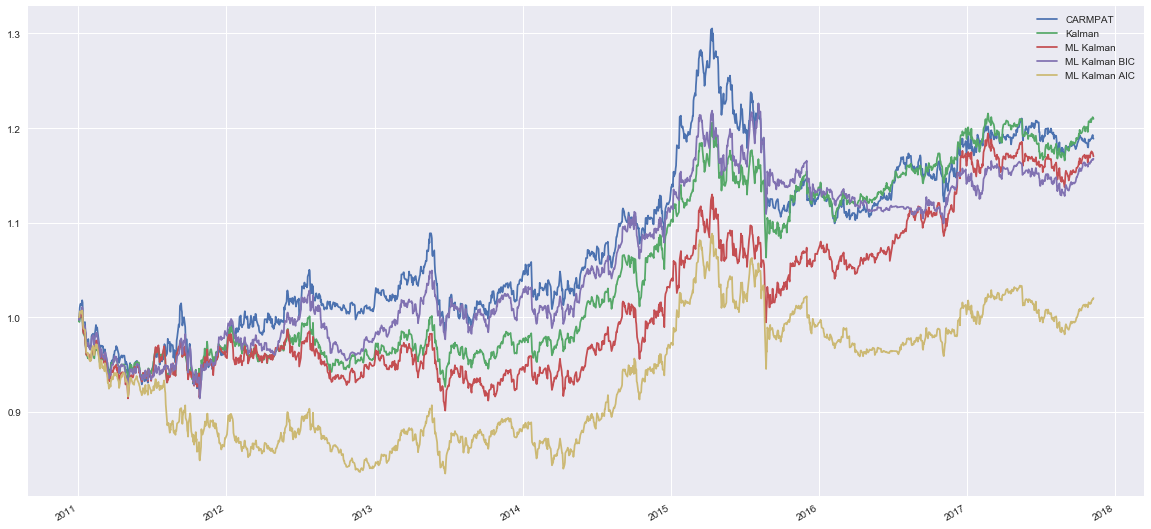

In [22]:
temp = df_res.loc['2011':]
temp = (temp / temp.iloc[0])
temp[[fund_name, 'Kalman', 'ML Kalman', 'ML Kalman BIC', 'ML Kalman AIC']].plot(figsize=(20,10))

In [23]:
df_stat = replication_stats(df_res, fund_name=fund_name)
df_stat

,Correlation,Kendall tau,Tracking error,R-squared,Sharpe ratio,Annual Return,Maximum Drawdown
CARMPAT,1.000000,1.000000,0.000000,1.000000,0.562730,0.043992,-0.154378
Lasso AIC,0.773381,0.579000,0.052939,0.590672,0.475272,0.025686,-0.129633
Lasso BIC,0.740338,0.539556,0.058558,0.499178,0.376259,0.015334,-0.119652
Kalman,0.814012,0.621968,0.048361,0.658415,0.641765,0.044918,-0.140599
ML Kalman,0.769184,0.587230,0.055891,0.543752,0.499474,0.038135,-0.209265
Kalman AIC,0.740026,0.552847,0.056220,0.538370,0.456796,0.029583,-0.138092
ML Kalman AIC,0.751453,0.554141,0.058839,0.494351,0.335345,0.024925,-0.242133
Kalman BIC,0.707926,0.508262,0.058457,0.500901,0.271367,0.014540,-0.198294
ML Kalman BIC,0.754005,0.542405,0.055053,0.557330,0.342911,0.022066,-0.190594


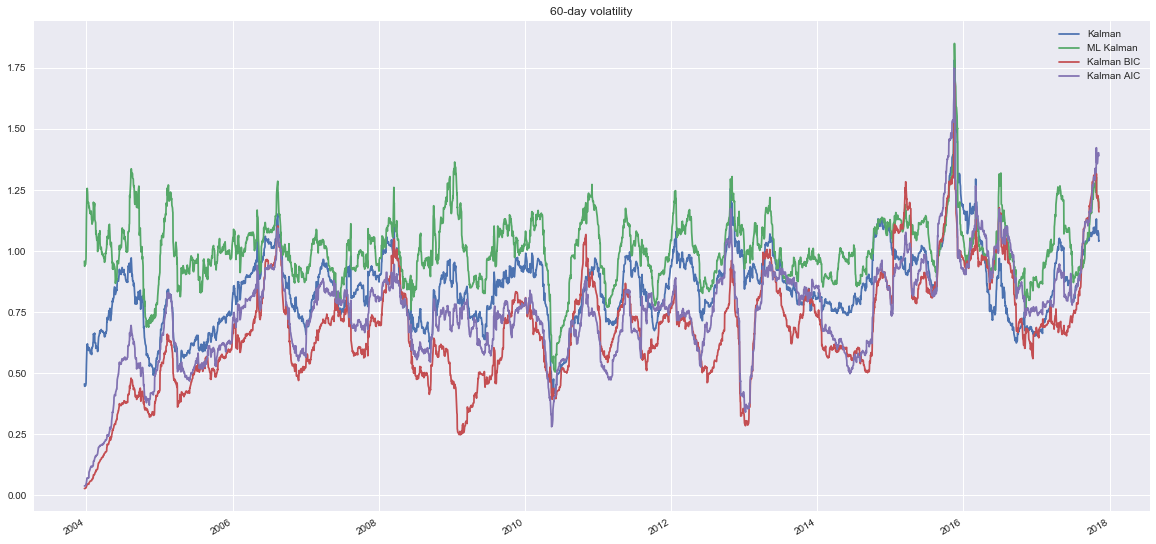

In [24]:
vol = df_res.pct_change().rolling(window=60).std().dropna()
(vol.T / vol[fund_name]).T[['Kalman', 'ML Kalman', 'Kalman BIC', 'Kalman AIC']].plot(figsize=(20,10), title='60-day volatility')

### Volatility adjustment

In [25]:
%%time
df_weight_kalman_aic_voladj = selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='aic', vol_target=True, vol_period=size)
df_weight_kalman_bic_voladj = selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='bic', vol_target=True, vol_period=size)
df_weight_kalman_voladj = kalman_filter(hrfx_returns, returns_all,freq, sigma_weight=1. , sigma_return=nu,
                                        vol_target=True, vol_period=size)
df_weight_ml_kalman_voladj, _ = ml_kalman_filter(hrfx_returns, returns_all,freq, tau=tau, vol_target=True, vol_period=size)

df_weight_kalman_aic_voladj_ml = ml_selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq_ml,\
                                          tau=tau, criterion='aic', vol_target=True, vol_period=size)

df_weight_kalman_bic_voladj_ml = ml_selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq_ml,\
                                          tau=tau, criterion='bic', vol_target=True, vol_period=size)


prices_for_track = prices_all.loc[df_weight_kalman_voladj.index[0]:]

replication_kalman_voladj = make_track(prices_for_track, df_weight_kalman_voladj, tc=tc, lag=lag)
df_res_voladj = hfrx.loc[replication_kalman_voladj.index]
df_res_voladj["Kalman"] = replication_kalman_voladj

replication_ml_kalman_voladj = make_track(prices_for_track, df_weight_ml_kalman_voladj, tc=tc, lag=lag)
df_res_voladj["ML Kalman"] = replication_ml_kalman_voladj

prices_for_track = prices_all.loc[df_weight_kalman_aic_voladj.index[0]:]

replication_kalman_bic_voladj = make_track(prices_for_track, df_weight_kalman_bic_voladj, tc=tc, lag=lag)
df_res_voladj["Kalman BIC"] = replication_kalman_bic_voladj

replication_kalman_aic_voladj = make_track(prices_for_track, df_weight_kalman_aic_voladj, tc=tc, lag=lag)
df_res_voladj["Kalman AIC"] = replication_kalman_aic_voladj

replication_kalman_bic_voladj_ml = make_track(prices_for_track, df_weight_kalman_bic_voladj_ml, tc=tc, lag=lag)
df_res_voladj["Kalman BIC ML"] = replication_kalman_bic_voladj_ml

replication_kalman_aic_voladj_ml = make_track(prices_for_track, df_weight_kalman_aic_voladj_ml, tc=tc, lag=lag)
df_res_voladj["Kalman AIC ML"] = replication_kalman_aic_voladj_ml

Wall time: 2min 34s


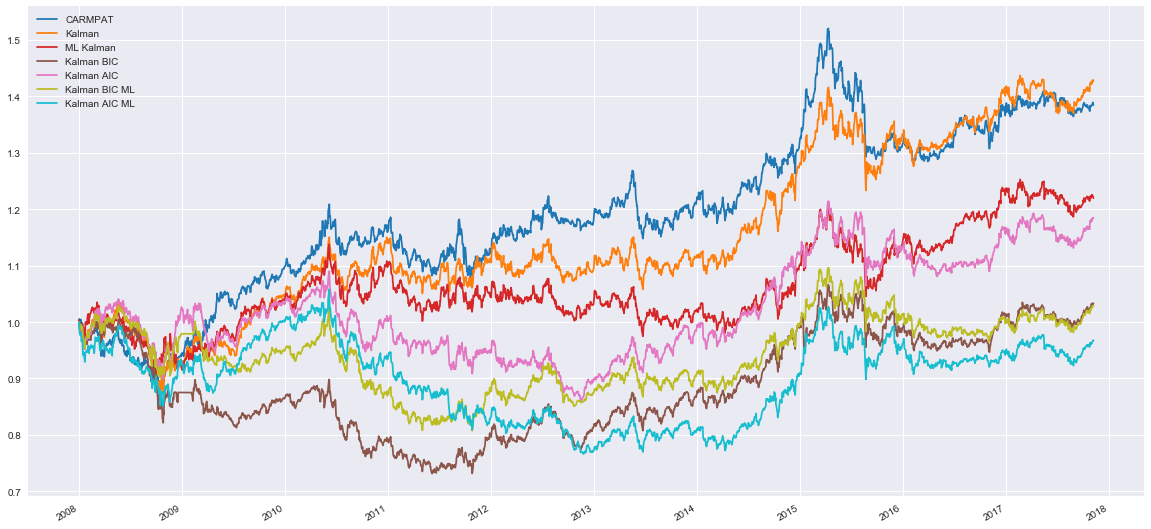

In [55]:
df_res_voladj = df_res_voladj.loc['2008':]
df_res_voladj = (df_res_voladj / df_res_voladj.iloc[0])
df_res_voladj.plot(figsize=(20,10),cmap="tab10")

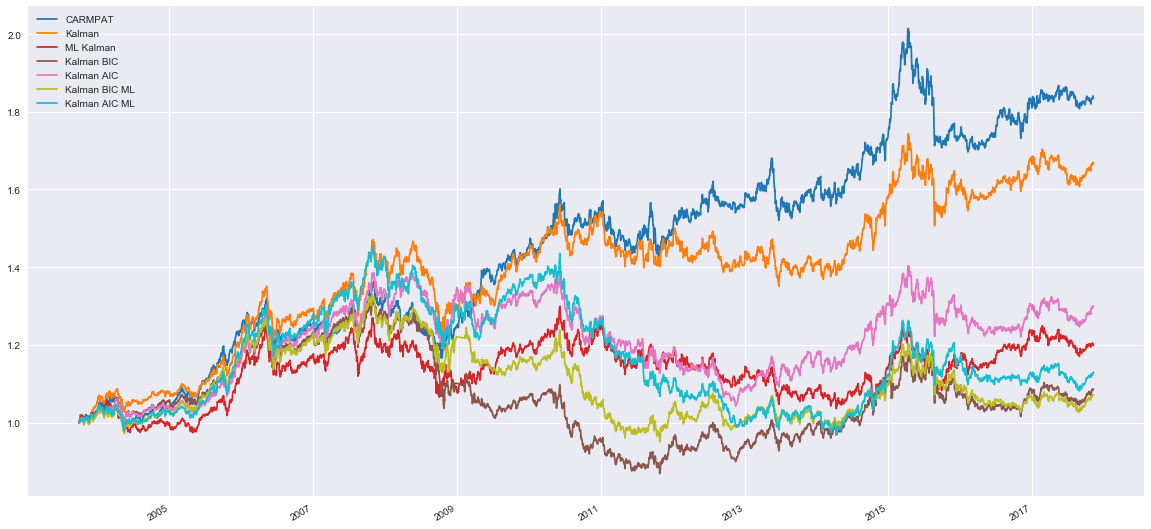

In [27]:
df_res_volperfadj = df_res_voladj[[fund_name]].copy()
temp = df_res_voladj.drop(fund_name, axis=1)
df_res_volperfadj[temp.columns]= make_ER(temp, 2 + 0 * US_rate)
df_res_volperfadj.plot(figsize=(20,10),cmap="tab10")

## Statistics on replication

In [28]:
df_stat_vol = replication_stats(df_res_voladj, fund_name=fund_name)
df_stat_vol

,Correlation,Kendall tau,Tracking error,R-squared,Sharpe ratio,Annual Return,Maximum Drawdown
CARMPAT,1.000000,1.000000,0.000000,1.000000,0.562730,0.043992,-0.154378
Kalman,0.806780,0.620120,0.052825,0.592441,0.694527,0.058001,-0.152176
ML Kalman,0.766074,0.566238,0.058193,0.505398,0.425412,0.033727,-0.142817
Kalman BIC,0.703585,0.520951,0.064839,0.385978,0.347325,0.026348,-0.283433
Kalman AIC,0.745269,0.564692,0.061309,0.451011,0.482797,0.039451,-0.207555
Kalman BIC ML,0.737939,0.536888,0.059535,0.482332,0.348032,0.025367,-0.214175
Kalman AIC ML,0.750051,0.548817,0.060331,0.468389,0.372577,0.029116,-0.275779


## Volatility contributions

In [29]:
df_weight_kalman_voladj_ = df_weight_kalman_voladj.loc['2008':]
df_vol_contrib_kalman_voladj = (prices_all.reindex(df_weight_kalman_voladj_.index).pct_change()*df_weight_kalman_voladj_).std()
df_vol_contrib_kalman_voladj = df_vol_contrib_kalman_voladj/df_vol_contrib_kalman_voladj.sum()

df_weight_kalman_bic_voladj_ = df_weight_kalman_bic_voladj.loc['2008':]
df_vol_contrib_kalman_bic_voladj = (prices_all.reindex(df_weight_kalman_bic_voladj_.index).pct_change()*df_weight_kalman_bic_voladj_).std()
df_vol_contrib_kalman_bic_voladj = df_vol_contrib_kalman_bic_voladj/df_vol_contrib_kalman_bic_voladj.sum()

df_weight_kalman_aic_voladj_ml_ = df_weight_kalman_aic_voladj.loc['2008':]
df_vol_contrib_kalman_aic_voladj_ml = (prices_all.reindex(df_weight_kalman_aic_voladj_ml_.index).pct_change()*df_weight_kalman_aic_voladj_ml_).std()
df_vol_contrib_kalman_aic_voladj_ml = df_vol_contrib_kalman_aic_voladj_ml/df_vol_contrib_kalman_aic_voladj_ml.sum()

In [30]:
df_vol_contrib = pd.DataFrame()
df_vol_contrib["Kalman"] = df_vol_contrib_kalman_voladj
df_vol_contrib["Kalman BIC"] = df_vol_contrib_kalman_bic_voladj
df_vol_contrib["Kalman AIC ML"] = df_vol_contrib_kalman_aic_voladj_ml
df_vol_contrib = df_vol_contrib.join(df_info).reset_index()

In [31]:
df_vol_contrib_asset_class = df_vol_contrib.drop(["Style"],axis=1).groupby(["Asset Class","index"]).sum()
df_vol_contrib_style = df_vol_contrib.drop(["Asset Class"],axis=1).groupby(["Style","index"]).sum()

In [32]:
g = hc_spiderweb(df_vol_contrib_asset_class, title="Vol contribution by Asset Class")
g.plot()

In [33]:
g = hc_spiderweb(df_vol_contrib_style, title="Vol contribution by Style")
g.plot()

In [34]:
g = hc_piechart(df_vol_contrib_asset_class[["Kalman AIC ML"]], title="Vol contribution by Asset Class in Kalman AIC ML")
g.plot()

In [35]:
g = hc_piechart(df_vol_contrib_style[["Kalman AIC ML"]], title="Vol contribution by Style in Kalman BIC")
g.plot()

## Performance contributions

In [36]:
df_perf_contrib_kalman_voladj = (1 + prices_all.reindex(df_weight_kalman_voladj_.index).pct_change()*df_weight_kalman_voladj_).prod() - 1

df_perf_contrib_kalman_bic_voladj = (1 + prices_all.reindex(df_weight_kalman_bic_voladj_.index).pct_change()*df_weight_kalman_bic_voladj_).prod() - 1

df_perf_contrib_kalman_aic_voladj_ml = (1 + prices_all.reindex(df_weight_kalman_aic_voladj_ml_.index).pct_change()*df_weight_kalman_aic_voladj_ml_).prod() - 1

In [37]:
df_perf_contrib = pd.DataFrame()
df_perf_contrib["Kalman"] = df_perf_contrib_kalman_voladj
df_perf_contrib["Kalman BIC"] = df_perf_contrib_kalman_bic_voladj
df_perf_contrib["Kalman AIC ML"] = df_perf_contrib_kalman_aic_voladj_ml
df_perf_contrib = df_perf_contrib.join(df_info).reset_index()

In [38]:
df_perf_contrib_asset_class = df_perf_contrib.drop(["Style"],axis=1).groupby(["Asset Class","index"]).sum()
df_perf_contrib_style = df_perf_contrib.drop(["Asset Class"],axis=1).groupby(["Style","index"]).sum()

In [39]:
g = hc_spiderweb(df_perf_contrib_asset_class, title="Vol contribution by Asset Class")
g.plot()

In [40]:
g = hc_spiderweb(df_perf_contrib_style, title="Vol contribution by Style")
g.plot()

## Average exposures

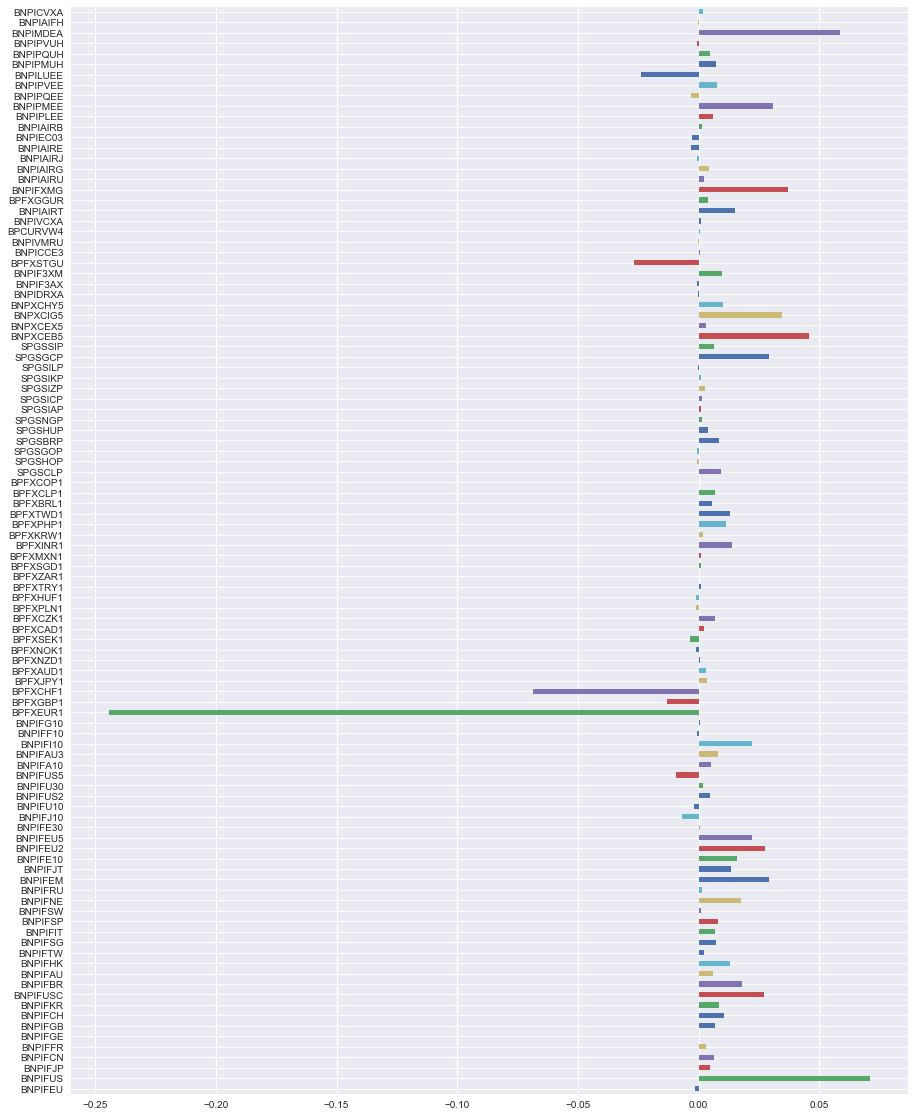

In [41]:
(df_weight_kalman_aic_voladj_ml).mean(axis=0).plot(kind='barh', figsize=(15,20))

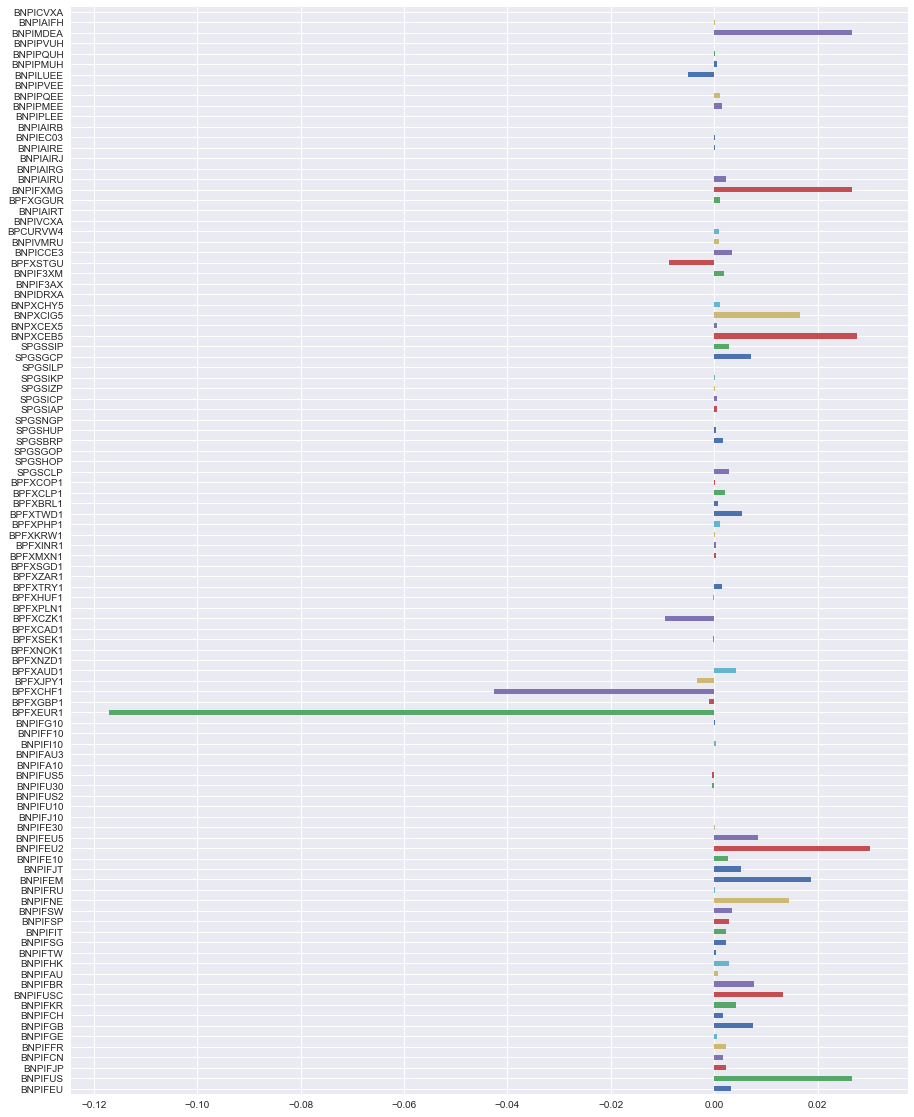

In [42]:
(df_weight_bic).mean(axis=0).plot(kind='barh', figsize=(15,20))

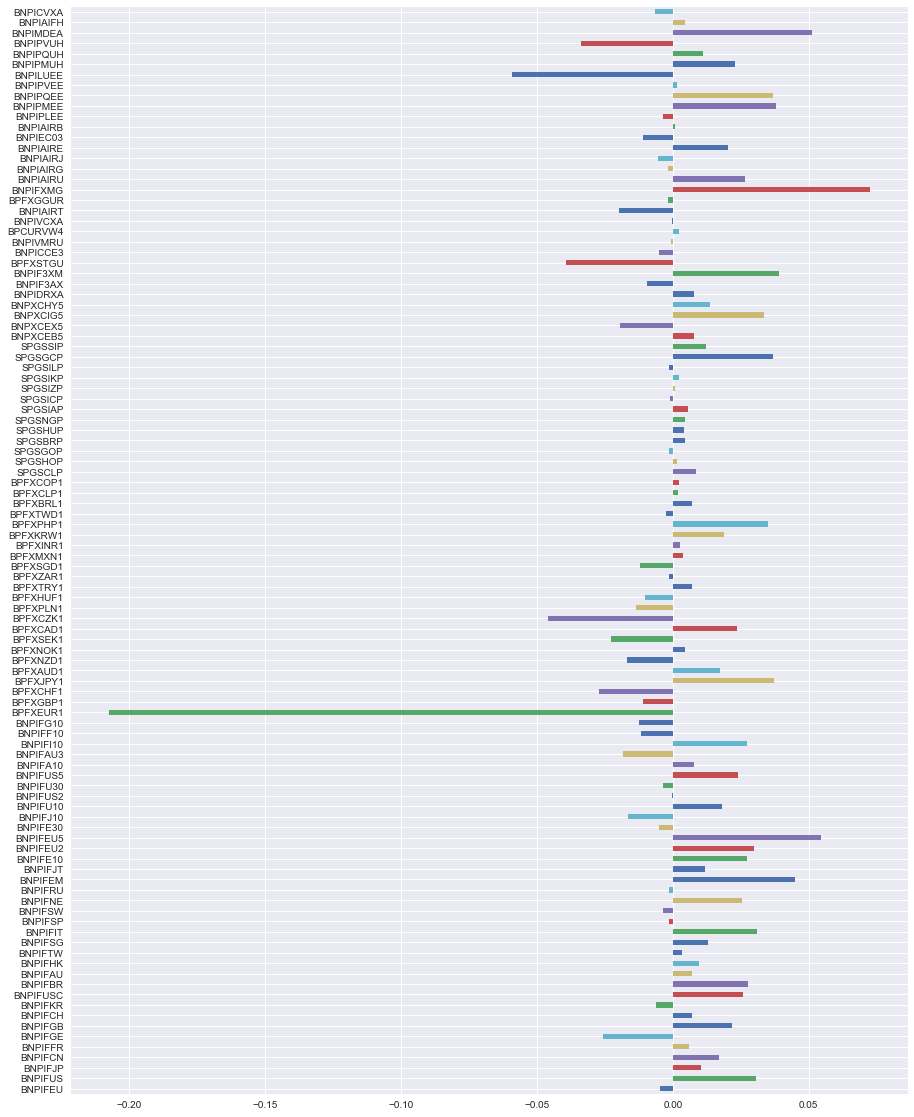

In [43]:
df_weight_kalman.loc[df_res.index[0]:].mean(axis=0).plot(kind='barh', figsize=(15,20))

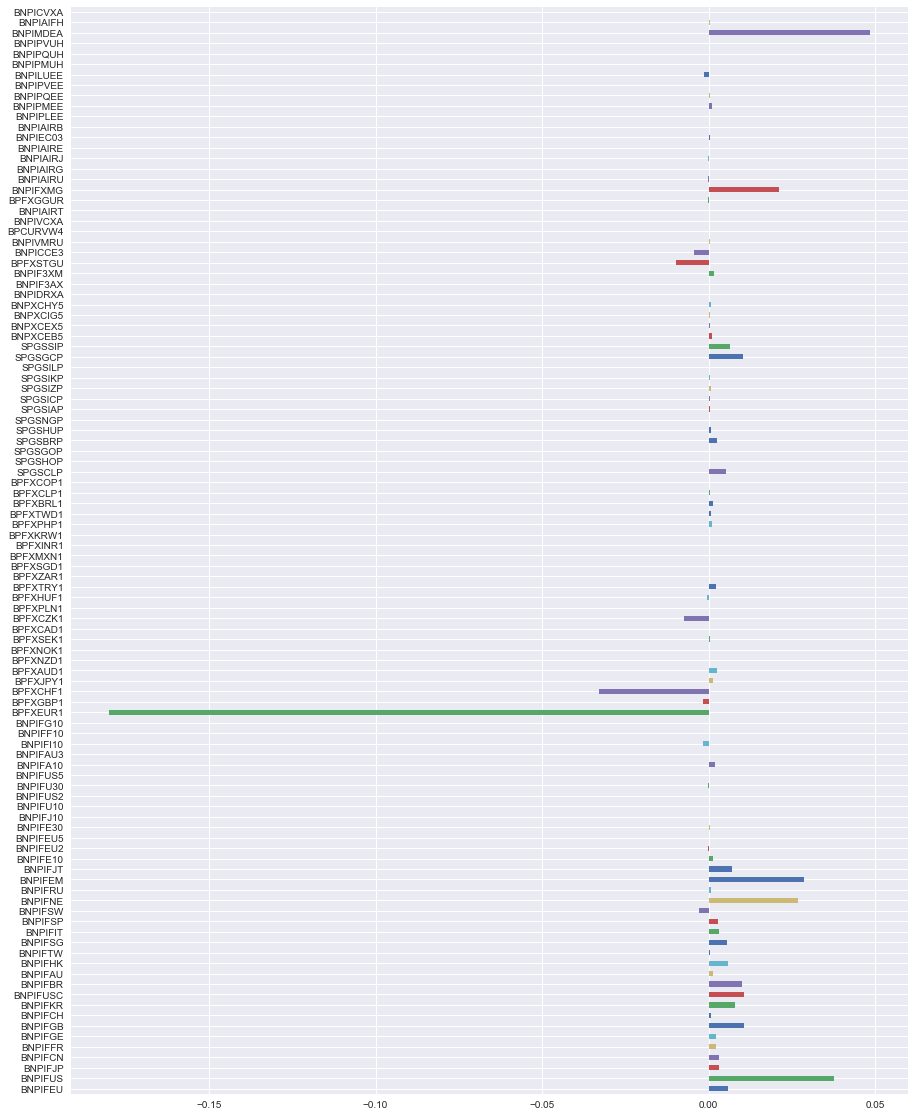

In [44]:
df_weight_kalman_bic.loc[df_res.index[0]:].mean(axis=0).plot(kind='barh', figsize=(15,20))

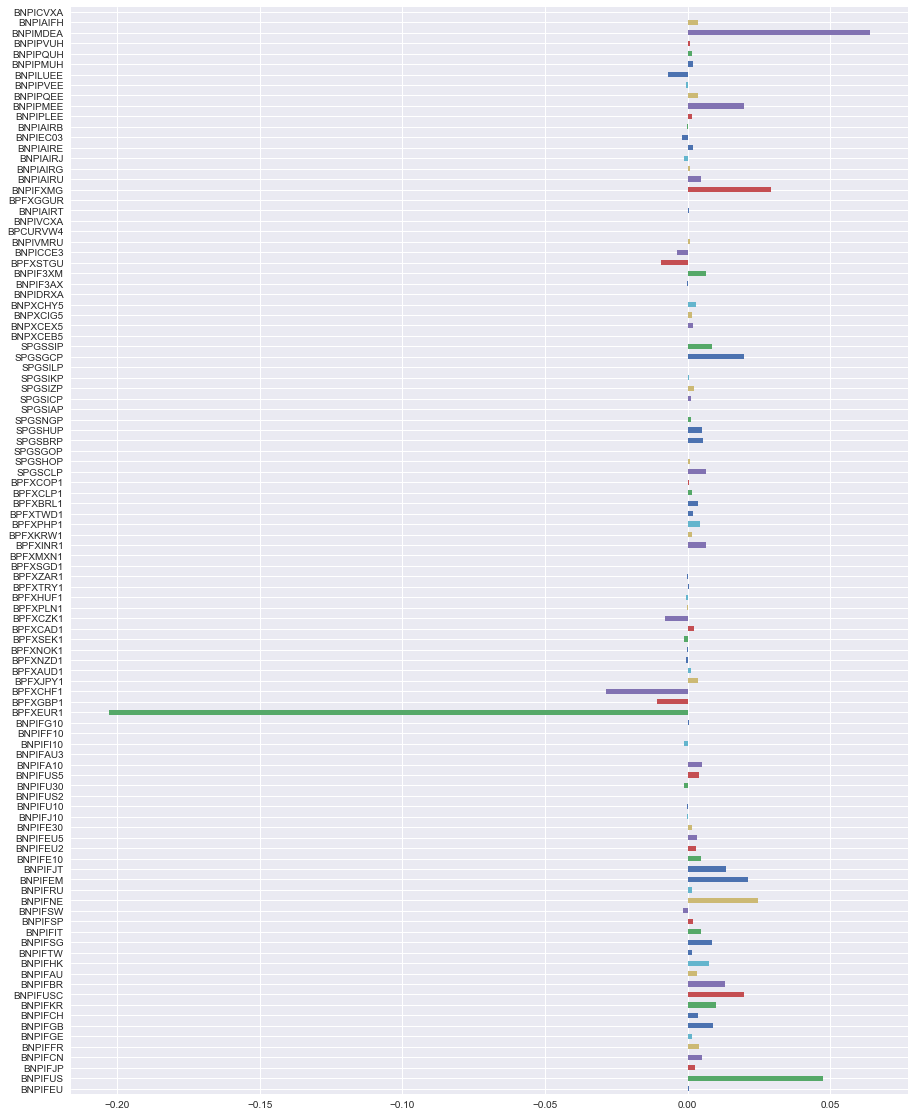

In [45]:
df_weight_kalman_aic.loc[df_res.index[0]:].mean(axis=0).plot(kind='barh', figsize=(15,20))

In [46]:
limit = 60
df_autocorr = pd.DataFrame(data=[df_res.drop(["Lasso AIC","Lasso BIC"],axis=1)\
                                 .pct_change().apply(lambda col : col.autocorr(lag=i)) for i in range(1,limit)])
df_autocorr[r"$2/\sqrt{n}$"] = [2/np.sqrt(len(df_res)-i) for i in range(1,limit)]
df_autocorr[r"$-2/\sqrt{n}$"] = [-2/np.sqrt(len(df_res)-i) for i in range(1,limit)]

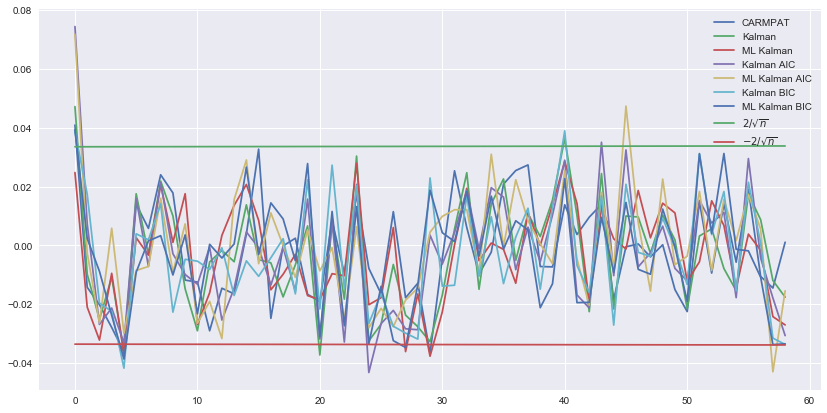

In [47]:
df_autocorr.plot(figsize=(14,7))

In [48]:
df_res[fund_name].pct_change().autocorr(lag=1)

0.040920762062632454

In [49]:
df_res['Kalman'].pct_change().autocorr(lag=1)

0.04718383698665926

In [50]:
df_res['Kalman BIC'].pct_change().autocorr(lag=1)

0.038731283449977165

In [51]:
df_res['Kalman AIC'].pct_change().autocorr(lag=1)

0.0743798393073209

In [52]:
df_res['Lasso AIC'].pct_change().autocorr(lag=1)

0.06184199368554535